# Required

In [1]:
import os
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
path = '/content/gdrive/MyDrive/ColabNotebooks/imagedb_btsd.zip'

In [4]:
local_zip = 'imagedb_btsd.zip'
zip_ref = zipfile.ZipFile(path, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
train_dir = 'imagedb'
validation_dir = 'imagedb_test'

# Φάκελος αποθήκευσης augmented εικόνων
augmented_dir = "augmented_data"
os.makedirs(augmented_dir, exist_ok=True)

val_dir = 'val_dir'
test_dir = 'test_dir'

# Δημιουργία νέων φακέλων
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Διαχωρισμός val-set (15%) και test-set (85%)
for category in os.listdir(validation_dir):
    category_path = os.path.join(validation_dir, category)
    if os.path.isdir(category_path):
        files = os.listdir(category_path)
        train_files, val_files = train_test_split(files, test_size=0.15, random_state=42)

        os.makedirs(os.path.join(val_dir, category), exist_ok=True)
        os.makedirs(os.path.join(test_dir, category), exist_ok=True)

        # Μετακίνηση αρχείων στο val_dir
        for file in val_files:
            shutil.move(os.path.join(category_path, file), os.path.join(val_dir, category, file))

        # Μετακίνηση αρχείων στο test_dir
        for file in train_files:
            shutil.move(os.path.join(category_path, file), os.path.join(test_dir, category, file))

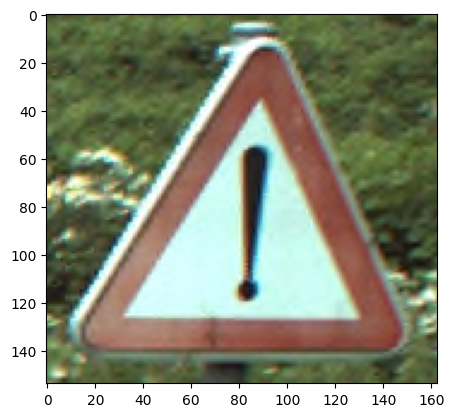

In [6]:
img_path = "/content/imagedb/00013/00138_00000.ppm"
img = mpimg.imread(img_path)
plt.imshow(img, cmap='gray')

plt.show()

# NOT pre-trained

In [7]:
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(28, 28),
    batch_size=80,
    class_mode='categorical',
    color_mode='rgb'
    #color_mode='grayscale'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(28, 28),
    batch_size=80,
    class_mode='categorical',
    color_mode='rgb'
    #color_mode='grayscale'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(28, 28),
    batch_size=80,
    class_mode='categorical',
    color_mode='rgb'
    #color_mode='grayscale'
)

Found 3056 images belonging to 34 classes.
Found 339 images belonging to 34 classes.
Found 1810 images belonging to 34 classes.


In [ ]:
# Δημιουργία Data Augmentation με random crop και zoom

augmented_generator = ImageDataGenerator(
    rescale=1.0 / 255.0,    # Κανονικοποίηση
    zoom_range=0.2,         # Εφαρμογή zoom
    height_shift_range=0.2, # Μετατόπιση ύψους
    width_shift_range=0.2,  # Μετατόπιση πλάτους
    preprocessing_function=lambda img: tf.image.resize(
        tf.image.random_crop(img, size=(24, 24, 3)), (28, 28)
    )
)

augmented_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(28, 28),
    batch_size=80,
    class_mode='categorical',
    #save_to_dir=augmented_dir,
    save_prefix="aug",
    save_format="jpeg"
)

total_images = len(train_generator.filenames)  # Συνολικός αριθμός εικόνων στο train set
augmented_images_count = total_images // 4     # 1/4 των εικόνων

# Δημιουργία batch augmented δεδομένων
augmented_images = []
augmented_labels = []

for i in range(augmented_images_count // train_generator.batch_size):
    batch_data, batch_labels = next(train_generator)  # Παίρνουμε ένα batch δεδομένων
    augmented_images.append(batch_data)
    augmented_labels.append(batch_labels)

images_to_save_per_class = 2

# Λεξικό για την παρακολούθηση αποθηκευμένων εικόνων ανά κατηγορία
saved_images_per_class = {class_name: 0 for class_name in train_generator.class_indices.keys()}

# Αποθήκευση augmented εικόνων στη σωστή δομή φακέλων
for batch_data, batch_labels in train_generator:
    for j, img in enumerate(batch_data):
        # Υπολογισμός της σωστής κατηγορίας
        class_idx = tf.argmax(batch_labels[j]).numpy()
        class_name = list(train_generator.class_indices.keys())[class_idx]

        # Έλεγχος αν έχουν ήδη αποθηκευτεί 2 εικόνες για την κατηγορία
        if saved_images_per_class[class_name] >= images_to_save_per_class:
            continue

        # Δημιουργία φακέλου για την κατηγορία, αν δεν υπάρχει ήδη
        class_dir = os.path.join(augmented_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

        img_filename = f"aug_{class_name}_{saved_images_per_class[class_name]}.jpeg"
        img_path = os.path.join(class_dir, img_filename)
        tf.keras.utils.save_img(img_path, img)

        saved_images_per_class[class_name] += 1

        #print(f"Αποθηκεύτηκε εικόνα: {img_filename} στη κατηγορία: {class_name}")

    # Διακοπή όταν όλες οι κατηγορίες έχουν 2 εικόνες
    if all(count >= images_to_save_per_class for count in saved_images_per_class.values()):
        break

print(f"Αποθηκεύτηκαν συνολικά 2 εικόνες για κάθε κατηγορία στο {augmented_dir}.")

augmented_images = np.concatenate(augmented_images)
augmented_labels = np.concatenate(augmented_labels)

print(f"Augmented images: {augmented_images.shape}, Augmented labels: {augmented_labels.shape}")

Found 3056 images belonging to 34 classes.
Αποθηκεύτηκαν συνολικά 2 εικόνες για κάθε κατηγορία στο augmented_data.
Augmented images: (720, 28, 28, 3), Augmented labels: (720, 34)


In [ ]:
# Δημιουργία Data Augmentation με ασπρόμαυρες εικόνες

bw_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    zoom_range=0.2,
    preprocessing_function=lambda img: tf.image.rgb_to_grayscale(img)
)


bw_generator = bw_datagen.flow_from_directory(
    train_dir,
    target_size=(28, 28),
    batch_size=80,
    class_mode='categorical',
    save_prefix="bw_aug",
    save_format="jpeg"
)


images_to_save_per_class = 2

# Λεξικό για την παρακολούθηση αποθηκευμένων εικόνων ανά κατηγορία
saved_images_per_class = {class_name: 0 for class_name in train_generator.class_indices.keys()}

# Αποθήκευση augmented εικόνων στη σωστή δομή φακέλων
for batch_data, batch_labels in train_generator:
    for j, img in enumerate(batch_data):
        # Υπολογισμός της σωστής κατηγορίας
        class_idx = tf.argmax(batch_labels[j]).numpy()
        class_name = list(train_generator.class_indices.keys())[class_idx]

        # Έλεγχος αν έχουν ήδη αποθηκευτεί 2 εικόνες για την κατηγορία
        if saved_images_per_class[class_name] >= images_to_save_per_class:
            continue

        # Δημιουργία φακέλου για την κατηγορία, αν δεν υπάρχει ήδη
        class_dir = os.path.join(augmented_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

        img_filename = f"bw_aug_{class_name}_{saved_images_per_class[class_name]}.jpeg"
        img_path = os.path.join(class_dir, img_filename)
        tf.keras.utils.save_img(img_path, img)

        saved_images_per_class[class_name] += 1

        #print(f"Αποθηκεύτηκε εικόνα: {img_filename} στη κατηγορία: {class_name}")

    # Διακοπή όταν όλες οι κατηγορίες έχουν 2 εικόνες
    if all(count >= images_to_save_per_class for count in saved_images_per_class.values()):
        break

print(f"Αποθηκεύτηκαν συνολικά 2 εικόνες για κάθε κατηγορία στο {augmented_dir}.")

Found 3056 images belonging to 34 classes.
Αποθηκεύτηκαν συνολικά 2 εικόνες για κάθε κατηγορία στο augmented_data.


In [ ]:
# Αντιγραφή εικόνων από το augmented_dir στο train_dir

categories = os.listdir(train_dir)

for category in categories:
    train_category_path = os.path.join(train_dir, category)
    augmented_category_path = os.path.join(augmented_dir, category)

    # Ελέγχουμε αν η κατηγορία υπάρχει και στο augmented_dir
    if not os.path.exists(augmented_category_path):
        print(f"Ο φάκελος {augmented_category_path} δεν υπάρχει. Παραλείπεται.")
        continue

    # Αντιγραφή εικόνων από το augmented_dir στο αντίστοιχο train_dir
    for img_file in os.listdir(augmented_category_path):
        src = os.path.join(augmented_category_path, img_file)
        dst = os.path.join(train_category_path, img_file)
        shutil.copy(src, dst)

print(f"Οι εικόνες από το {augmented_dir} αντιγράφηκαν επιτυχώς στο {train_dir}.")

Οι εικόνες από το augmented_data αντιγράφηκαν επιτυχώς στο imagedb.


In [8]:
# Συνάρτηση για δημιουργία ενός Block
def add_block(model, filters, kernel_size=(3, 3), pool_size=(2, 2), dropout_rate=0.25):
    model.add(tf.keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), activation='relu', padding='same'))
    model.add(tf.keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), activation='relu', padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=pool_size, strides=(2, 2)))
    model.add(tf.keras.layers.Dropout(dropout_rate))

# Δημιουργία μοντέλου Sequential
model = tf.keras.models.Sequential()

# Input Layer
model.add(tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), activation='relu', input_shape=(28, 28, 3)))

# Προσθήκη blocks δυναμικά
filters_list = [32, 64, 128, 256]  # Αύξηση φίλτρων ανά block
dropout_rates = [0.5, 0.25, 0.125, 0.0625]

for filters, dropout_rate in zip(filters_list, dropout_rates):
    add_block(model, filters, dropout_rate=dropout_rate)

# Classifier
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(2048, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dense(34, activation='softmax'))  # Αριθμός κατηγοριών

# Σύνταξη του μοντέλου
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Επισκόπηση του μοντέλου
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 26, 26, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 26, 26, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 13, 13, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 6, 6, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 6, 6, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 3, 3, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 3, 3, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │         526,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,840,866 (14.65 MB)

 Trainable params: 3,840,866 (14.65 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
callbacks = []

# Αποθήκευση των καλύτερων βαρών με σωστή κατάληξη
save_best_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_weights.keras',
    save_best_only=True,
    verbose=1
)
callbacks.append(save_best_callback)

# Πρόωρη διακοπή
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True, verbose=1
)
callbacks.append(early_stop_callback)

# Εκπαίδευση του μοντέλου
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=100,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    verbose=1,
    callbacks=callbacks
)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.0827 - loss: 3.8219
Epoch 1: val_loss improved from inf to 3.33735, saving model to best_weights.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 243ms/step - accuracy: 0.0826 - loss: 3.8010 - val_accuracy: 0.0938 - val_loss: 3.3373
Epoch 2/100
 1/38 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1125 - loss: 3.2047

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 3.33735
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.1125 - loss: 3.2047 - val_accuracy: 0.1053 - val_loss: 3.3529
Epoch 3/100
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1233 - loss: 3.1189
Epoch 3: val_loss improved from 3.33735 to 2.98017, saving model to best_weights.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.1246 - loss: 3.1154 - val_accuracy: 0.2500 - val_loss: 2.9802
Epoch 4/100
 1/38 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1625 - loss: 2.8187
Epoch 4: val_loss improved from 2.98017 to 2.61267, saving model to best_weights.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1625 - loss: 2.8187 - val_accuracy: 0.2632 - val_loss: 2.6127
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1703 - loss: 2.6429
Epoch 5: val_loss improved from 2.61267 to 2.48610, saving model to best_weights.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.1707 - loss: 2.6411 - val_accura

In [10]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(28, 28),
    batch_size=80,
    class_mode='categorical',
    color_mode='rgb'
)

# Αξιολόγηση του μοντέλου
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc}")

Found 1810 images belonging to 34 classes.
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.9738 - loss: 0.2131
Test Accuracy: 0.9701657295227051


# ResNet50

In [ ]:
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_dir,
    #rescale=1.0 / 255.0,
    target_size=(224, 224),
    batch_size=80,
    class_mode='categorical',
    color_mode='rgb'
    #color_mode='grayscale'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    #rescale=1.0 / 255.0,
    target_size=(224, 224),
    batch_size=80,
    class_mode='categorical',
    color_mode='rgb'
    #color_mode='grayscale'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    #rescale=1.0 / 255.0,
    target_size=(224, 224),
    batch_size=80,
    class_mode='categorical',
    color_mode='rgb'
    #color_mode='grayscale'
)

Found 3056 images belonging to 34 classes.
Found 339 images belonging to 34 classes.
Found 1810 images belonging to 34 classes.


In [ ]:
# Δημιουργία Data Augmentation με random crop και zoom

augmented_generator = ImageDataGenerator(
    rescale=1.0 / 255.0,    # Κανονικοποίηση
    zoom_range=0.2,         # Εφαρμογή zoom
    height_shift_range=0.2, # Μετατόπιση ύψους
    width_shift_range=0.2,  # Μετατόπιση πλάτους
    preprocessing_function=lambda img: tf.image.resize(
        tf.image.random_crop(img, size=(224, 224, 3)), (224, 224)
    )
)

augmented_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=80,
    class_mode='categorical',
    save_prefix="aug",
    save_format="jpeg"
)

total_images = len(train_generator.filenames)  # Συνολικός αριθμός εικόνων στο train set
augmented_images_count = total_images // 4     # 1/4 των εικόνων

# Δημιουργία batch augmented δεδομένων
augmented_images = []
augmented_labels = []

for i in range(augmented_images_count // train_generator.batch_size):
    batch_data, batch_labels = next(train_generator)  # Παίρνουμε ένα batch δεδομένων
    augmented_images.append(batch_data)
    augmented_labels.append(batch_labels)

images_to_save_per_class = 2

# Λεξικό για την παρακολούθηση αποθηκευμένων εικόνων ανά κατηγορία
saved_images_per_class = {class_name: 0 for class_name in train_generator.class_indices.keys()}

# Αποθήκευση augmented εικόνων στη σωστή δομή φακέλων
for batch_data, batch_labels in train_generator:
    for j, img in enumerate(batch_data):
        # Υπολογισμός της σωστής κατηγορίας
        class_idx = tf.argmax(batch_labels[j]).numpy()
        class_name = list(train_generator.class_indices.keys())[class_idx]

        # Έλεγχος αν έχουν ήδη αποθηκευτεί 2 εικόνες για την κατηγορία
        if saved_images_per_class[class_name] >= images_to_save_per_class:
            continue

        # Δημιουργία φακέλου για την κατηγορία, αν δεν υπάρχει ήδη
        class_dir = os.path.join(augmented_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

        img_filename = f"aug_{class_name}_{saved_images_per_class[class_name]}.jpeg"
        img_path = os.path.join(class_dir, img_filename)
        tf.keras.utils.save_img(img_path, img)

        saved_images_per_class[class_name] += 1

        #print(f"Αποθηκεύτηκε εικόνα: {img_filename} στη κατηγορία: {class_name}")

    # Διακοπή όταν όλες οι κατηγορίες έχουν 2 εικόνες
    if all(count >= images_to_save_per_class for count in saved_images_per_class.values()):
        break

print(f"Αποθηκεύτηκαν συνολικά 2 εικόνες για κάθε κατηγορία στο {augmented_dir}.")


augmented_images = np.concatenate(augmented_images)
augmented_labels = np.concatenate(augmented_labels)


print(f"Augmented images: {augmented_images.shape}, Augmented labels: {augmented_labels.shape}")

Found 3056 images belonging to 34 classes.
Αποθηκεύτηκαν συνολικά 2 εικόνες για κάθε κατηγορία στο augmented_data.
Augmented images: (720, 224, 224, 3), Augmented labels: (720, 34)


In [ ]:
# Δημιουργία Data Augmentation με ασπρόμαυρες εικόνες

bw_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    zoom_range=0.2,
    preprocessing_function=lambda img: tf.image.rgb_to_grayscale(img)
)


bw_generator = bw_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=80,
    class_mode='categorical',
    save_prefix="bw_aug",
    save_format="jpeg"
)

images_to_save_per_class = 2

# Λεξικό για την παρακολούθηση αποθηκευμένων εικόνων ανά κατηγορία
saved_images_per_class = {class_name: 0 for class_name in train_generator.class_indices.keys()}

# Αποθήκευση augmented εικόνων στη σωστή δομή φακέλων
for batch_data, batch_labels in train_generator:
    for j, img in enumerate(batch_data):
        # Υπολογισμός της σωστής κατηγορίας
        class_idx = tf.argmax(batch_labels[j]).numpy()
        class_name = list(train_generator.class_indices.keys())[class_idx]

        # Έλεγχος αν έχουν ήδη αποθηκευτεί 2 εικόνες για την κατηγορία
        if saved_images_per_class[class_name] >= images_to_save_per_class:
            continue

        # Δημιουργία φακέλου για την κατηγορία, αν δεν υπάρχει ήδη
        class_dir = os.path.join(augmented_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

        img_filename = f"bw_aug_{class_name}_{saved_images_per_class[class_name]}.jpeg"
        img_path = os.path.join(class_dir, img_filename)
        tf.keras.utils.save_img(img_path, img)

        saved_images_per_class[class_name] += 1

        #print(f"Αποθηκεύτηκε εικόνα: {img_filename} στη κατηγορία: {class_name}")

    # Διακοπή όταν όλες οι κατηγορίες έχουν 2 εικόνες
    if all(count >= images_to_save_per_class for count in saved_images_per_class.values()):
        break

print(f"Αποθηκεύτηκαν συνολικά 2 εικόνες για κάθε κατηγορία στο {augmented_dir}.")


augmented_images = np.concatenate(augmented_images)
augmented_labels = np.concatenate(augmented_labels)


print(f"Augmented images: {augmented_images.shape}, Augmented labels: {augmented_labels.shape}")

Found 3056 images belonging to 34 classes.
Αποθηκεύτηκαν συνολικά 2 εικόνες για κάθε κατηγορία στο augmented_data.
Augmented images: (161280, 224, 3), Augmented labels: (24480,)


In [ ]:
# Fine - tuning

# Φόρτωση του ResNet50 με προ-εκπαιδευμένα βάρη από το ImageNet : 175 layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Layers που περιέχουν βάρη (trainable parameters) : 106 layers
layers_with_weights = [layer for layer in base_model.layers if layer.weights]
print(f"Αριθμός layers με βάρη: {len(layers_with_weights)}")

# Πάγωμα όλων των επιπέδων
for layer in layers_with_weights:
    layer.trainable = False

# Ξεπάγωμα των τελευταίων 26 επιπέδων
for layer in layers_with_weights[80:]:
    layer.trainable = True

print(f"Συνολικός αριθμός επιπέδων στη βάση του ResNet50: {len(base_model.layers)}")

frozen_layers = sum([1 for layer in layers_with_weights if not layer.trainable])
trainable_layers = sum([1 for layer in layers_with_weights if layer.trainable])

print(f"Παγωμένα επίπεδα: {frozen_layers}")
print(f"Μη παγωμένα επίπεδα: {trainable_layers}")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Αριθμός layers με βάρη: 106
Συνολικός αριθμός επιπέδων στη βάση του ResNet50: 175
Παγωμένα επίπεδα: 80
Μη παγωμένα επίπεδα: 26


In [ ]:
# Χρήση προ-εκπαιδευμένου δικτύου: ResNet50

# Προσαρμογή του δικτύου για το dataset
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.6),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(34, activation='softmax')  # 34 κατηγορίες
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 34)                  │           4,386 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,706,850 (94.25 MB)

 Trainable params: 17,213,858 (65.67 MB)

 Non-trainable params: 7,492,992 (28.58 MB)

In [ ]:
callbacks = []

# Αποθήκευση των καλύτερων βαρών με σωστή κατάληξη
save_best_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_weights.keras',
    save_best_only=True,
    verbose=1
)
callbacks.append(save_best_callback)

# Πρόωρη διακοπή
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True, verbose=1
)
callbacks.append(early_stop_callback)

# Εκπαίδευση του μοντέλου
history = model.fit(
    train_generator,
    validation_data=validation_generator,
   # steps_per_epoch=train_generator.samples // train_generator.batch_size,
    steps_per_epoch=50,
    epochs=60,
    validation_steps=35,
   # validation_steps=validation_generator.samples // validation_generator.batch_size,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/50 ━━━━━━━━━━━━━━━━━━━━ 7s 684ms/step - accuracy: 0.4891 - loss: 2.0509

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_loss improved from inf to 13.22488, saving model to best_weights.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 78s 779ms/step - accuracy: 0.5286 - loss: 1.8868 - val_accuracy: 0.5752 - val_loss: 13.2249
Epoch 2/60
39/50 ━━━━━━━━━━━━━━━━━━━━ 3s 290ms/step - accuracy: 0.8739 - loss: 0.4985
Epoch 2: val_loss did not improve from 13.22488
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 245ms/step - accuracy: 0.8766 - loss: 0.4915 - val_accuracy: 0.2419 - val_loss: 252.9183
Epoch 3/60
39/50 ━━━━━━━━━━━━━━━━━━━━ 3s 294ms/step - accuracy: 0.9185 - loss: 0.3387
Epoch 3: val_loss did not improve from 13.22488
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 253ms/step - accuracy: 0.9197 - loss: 0.3297 - val_accuracy: 0.3156 - val_loss: 32.3997
Epoch 4/60
39/50 ━━━━━━━━━━━━━━━━━━━━ 3s 296ms/step - accuracy: 0.9404 - loss: 0.2243
Epoch 4: val_loss improved from 13.22488 to 6.08465, saving model to best_weights.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 294ms/step - accuracy: 0.9421 - loss: 0.2176 - val_accuracy: 0.7109 - val_loss: 6.08

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=80,
    class_mode='categorical',
    color_mode='rgb'
)

# Αξιολόγηση του μοντέλου
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc}")

Found 1810 images belonging to 34 classes.
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 486ms/step - accuracy: 0.9287 - loss: 0.5947
Test Accuracy: 0.9397789835929871


# Plots

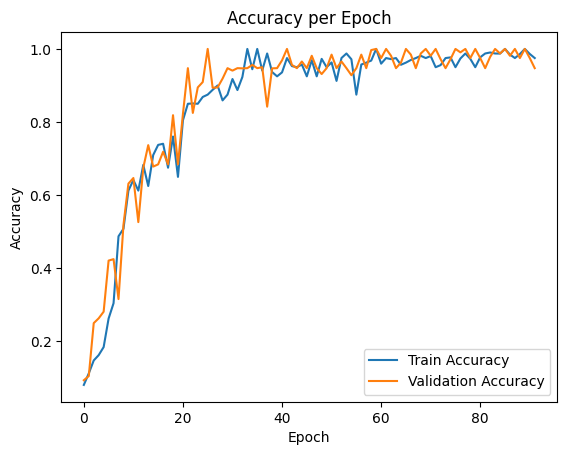

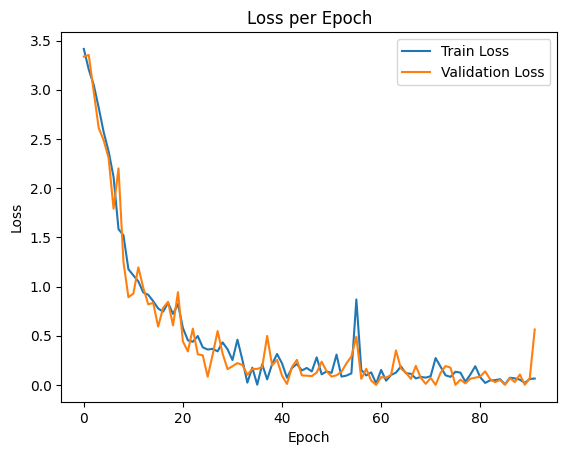

In [11]:
# Γράφημα ακρίβειας
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Γράφημα απώλειας
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()